<a href="https://colab.research.google.com/github/mmtondreau/HousingPrices/blob/main/House_Prices_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
! pip install pytorch_lightning

In [262]:
import os
import requests
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
import torch
from torch.utils.data import TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchmetrics import Accuracy, MeanMetric, MeanAbsoluteError
import torch.nn as nn

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

In [263]:
class HPDataModule(pl.LightningDataModule):
    REMOVE_FEATURES = []
    def __init__(self, data_dir: str = './', batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self) -> None:
        response = requests.get("https://raw.githubusercontent.com/mmtondreau/HousingPrices/refs/heads/main/train.csv")
        with open(os.path.join(self.data_dir, "train.csv"), "wb") as file:
            file.write(response.content)
        response = requests.get("https://raw.githubusercontent.com/mmtondreau/HousingPrices/refs/heads/main/test.csv")
        with open(os.path.join(self.data_dir, "test.csv"), "wb") as file:
            file.write(response.content)

    def setup(self, stage: str) -> None:
        train_data_df = pd.read_csv(os.path.join(self.data_dir, "train.csv"), index_col="Id")
        test_data_df = pd.read_csv(os.path.join(self.data_dir, "train.csv"), index_col="Id")

        self.test_dataset = self.generate_dataset(test_data_df)
        train_and_val_dataset = self.generate_dataset(train_data_df)

        self.train_dataset, self.val_dataset = train_test_split(train_and_val_dataset, test_size=0.2, random_state=42)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

    def generate_dataset(self, df):

        x_data_transformed = self.transform_data(df)
        y_data = df["SalePrice"]
        z_data = df.index
        assert len(x_data_transformed) == len(y_data) == len(z_data), "Mismatch in dataset sizes!"
        self.width = x_data_transformed.shape[1]

        return TensorDataset(
            torch.tensor(x_data_transformed.to_numpy(), dtype=torch.float32),
            torch.tensor(y_data.values, dtype=torch.float32).view(-1, 1),
            torch.tensor(z_data.values, dtype=torch.int32),
        )

    def one_hot(self, df, columns):
        if len(columns) == 0:
            return df
        for col in columns:
            categories = df[col].unique()
            category_to_index = {
                category: index for index, category in enumerate(categories)
            }
            df.loc[:, col] = df[col].map(category_to_index)
            num_categories = len(categories)

            values = df[col].astype(int).to_numpy()
            tensor_values = torch.tensor(values, dtype=torch.int64)
            one_hot_encoding = F.one_hot(tensor_values, num_classes=num_categories)
            one_hot_df = pd.DataFrame(one_hot_encoding.numpy(), columns=categories, index=df.index)
            df = pd.concat([df, one_hot_df], axis=1)

        return df

    def transform_data(self, df):
        train_df_tmp = df.loc[:, ~df.columns.isin(self.REMOVE_FEATURES)]
        train_df_tmp = self.one_hot(
            train_df_tmp, df.select_dtypes(include=["object", "string"]).columns.tolist()
        )

        # Add missing value indicators
        for col in ["LotFrontage", "MasVnrArea", "GarageYrBlt"]:
            if col in train_df_tmp.columns:
                train_df_tmp[f"{col}_missing"] = train_df_tmp[col].isna().astype(float)

        normalized_data = self.normalize(train_df_tmp)
        converted_data = normalized_data.apply(pd.to_numeric, errors='coerce')

        if converted_data.isna().any().any():
            print("[Debug] NaNs detected after transformation!")
            print(converted_data.isna().sum()[converted_data.isna().sum() > 0])

            # Specific column fixes before fallback to fillna
            for col in ["LotFrontage", "MasVnrArea", "GarageYrBlt"]:
                if col in converted_data.columns:
                    converted_data[col] = converted_data[col].fillna(converted_data[col].median())

            converted_data = converted_data.fillna(0)

        return converted_data

    def normalize(self, x):
        x_mean = np.mean(x, axis=0)
        x_std = np.std(x, axis=0)
        x_std[x_std == 0] = 1
        # Normalize each feature independently
        return (x - x_mean) / x_std

In [264]:
dm = HPDataModule()
dm.prepare_data()
dm.setup(stage="fit")

[Debug] NaNs detected after transformation!
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
[Debug] NaNs detected after transformation!
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [265]:


# x, y, z = next(iter(dm.train_dataloader()))
# print(x[0])
# print(y[0])

# df = dm.df

# print(df[df["ID"] == z[0].item()].to_string())

In [266]:
class HPLitModule(pl.LightningModule):
    def __init__(
        self,
        config,
        num_features,
        pytorch_model=None,
        num_classes=1,
    ):
        super().__init__()
        self.example_input_array = torch.Tensor(32, num_features)
        self.hidden_units = config["hidden_units"]
        self.learning_rate = config["learning_rate"]
        if pytorch_model is not None:
            self.model = pytorch_model
        else:
            self.model = HPModel(
                num_features=num_features,
                num_classes=num_classes,
                hidden_units=self.hidden_units,
            )

        self.loss_fn = torch.nn.SmoothL1Loss()
        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()
        self.val_loss = []
        self.save_hyperparameters()

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        loss, predictions, y = self._shared_eval(batch)
        mae = self.train_mae(predictions, y)

        # print(f"[Train Step] Loss: {loss.item()}, MAE: {mae.item()}")
        # print(f"Predictions: min={predictions.min().item()}, max={predictions.max().item()}")
        # print(f"Targets: min={y.min().item()}, max={y.max().item()}")

        total_norm = sum(
            p.grad.norm().item() for p in self.model.parameters() if p.grad is not None
        )
        # print(f"Gradient norm: {total_norm:.4f}")

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_mae", mae, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def on_validation_epoch_start(self):
        self.val_loss.clear()

    def validation_step(self, batch, batch_idx):
        loss, predictions, y = self._shared_eval(batch)
        mae = self.val_mae(predictions, y)

        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_mae", mae, prog_bar=True, on_step=True, on_epoch=True)
        self.val_loss.append(loss)

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_loss).mean()
        self.log("ptl/val_loss", avg_loss, sync_dist=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        loss, predictions, y = self._shared_eval(batch)
        mae = self.test_mae(predictions, y)
        self.log("test_loss", loss)
        self.log("test_mae", mae)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.learning_rate, weight_decay=0.001
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, patience=5, factor=0.1, mode="min"
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
            },
        }

    def _shared_eval(self, batch):
        x, y, _ = batch
        predictions = self(x)


        loss = self.loss_fn(predictions, y)
        return loss, predictions, y

In [267]:
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback

class PlotMetricsCallback(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        train_mae = trainer.callback_metrics.get("train_mae")
        if train_loss is not None and train_mae is not None:
            self.train_losses.append(train_loss.item())
            self.train_maes.append(train_mae.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        val_mae = trainer.callback_metrics.get("val_mae")
        if val_loss is not None and val_mae is not None:
            self.val_losses.append(val_loss.item())
            self.val_maes.append(val_mae.item())

    def on_train_end(self, trainer, pl_module):
        print("[PlotMetricsCallback] Training ended. Preparing to plot...")
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_maes), len(self.val_maes))
        print(f"Collected {min_len} epochs of data.")

        if min_len == 0:
            print("[PlotMetricsCallback] No metrics collected. Skipping plot.")
            return

        epochs = range(1, min_len + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses[:min_len], label="Train Loss")
        plt.plot(epochs, self.val_losses[:min_len], label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_maes[:min_len], label="Train MAE")
        plt.plot(epochs, self.val_maes[:min_len], label="Val MAE")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.title("MAE over Epochs")
        plt.legend()

        plt.tight_layout()
        plot_path = "metrics_plot.png"
        plt.savefig(plot_path)
        plt.close()
        print(f"[PlotMetricsCallback] Saved plot to {os.path.abspath(plot_path)}")



In [268]:
class Block(nn.Module):
    def __init__(self, input_size, hidden_units, dropout=0.1):
        super(Block, self).__init__()
        self.layer = nn.Linear(input_size, hidden_units)
        self.drop = nn.Dropout(dropout)
        self.batchNorm = nn.BatchNorm1d(hidden_units)
        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.layer(x)
        x = self.batchNorm(x)
        x = self.activation(x)
        x = self.drop(x)
        return x


class HPModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, hidden_units):
        super(HPModel, self).__init__()
        self.example_input_array = torch.Tensor(32, num_features)
        all_layers = []
        for hidden_unit in hidden_units:
            all_layers.append(Block(input_size=num_features, hidden_units=hidden_unit))
            num_features = hidden_unit
        all_layers.append(nn.Linear(hidden_units[-1], num_classes))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x):
        return self.layers(x).clamp(min=0)

In [269]:
config = {
    "hidden_units": [48, 24, 12],
    "learning_rate": 0.001,
    "batch_size": 64,
}
model = HPLitModule(config, num_features=dm.width)

In [270]:
 trainer = pl.Trainer(
    devices="auto",
    accelerator="auto",
    max_epochs=100,
    callbacks=[
        PlotMetricsCallback(),
        EarlyStopping(
            monitor="ptl/val_loss", mode="min", patience=5, min_delta=0.0001
        ),
        ModelCheckpoint(
            monitor="ptl/val_loss", mode="min", filename="{epoch}-{val_loss:.2f}"
        ),
    ],
)
trainer.fit(model, datamodule=dm)

trainer.test(model, datamodule=dm)

model.eval()

x, y, _ = next(iter(dm.test_dataloader()))
y_hat = model(x)
print(x)
print(torch.flatten(y))
print(torch.flatten(y_hat))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


[Debug] NaNs detected after transformation!
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode  | In sizes  | Out sizes
--------------------------------------------------------------------------------
0 | model     | HPModel           | 18.5 K | train | [32, 350] | [32, 1]  
1 | loss_fn   | SmoothL1Loss      | 0      | train | ?         | ?        
2 | train_mae | MeanAbsoluteError | 0      | train | ?         | ?        
3 | val_mae   | MeanAbsoluteError | 0      | train | ?         | ?        
4 | test_mae  | MeanAbsoluteError | 0      | train | ?         | ?        
--------------------------------------------------------------------------------
18.5 K    Trainable params
0         Non-trainable params
18.5 K    Total params
0.074     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


[Debug] NaNs detected after transformation!
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[PlotMetricsCallback] Training ended. Preparing to plot...
Collected 28 epochs of data.
[PlotMetricsCallback] Saved plot to /content/metrics_plot.png
[Debug] NaNs detected after transformation!
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[Debug] NaNs detected after transformation!
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       180917.265625       │
│         test_mae          │         180917.75         │
└───────────────────────────┴───────────────────────────┘

tensor([[ 0.0734, -0.4266, -0.2080,  ..., -0.4644, -0.0742, -0.2424],
        [-0.8726, -0.4266,  0.4099,  ..., -0.4644, -0.0742, -0.2424],
        [ 0.0734, -0.4266, -0.0844,  ..., -0.4644, -0.0742, -0.2424],
        ...,
        [-0.6361,  0.8265, -0.4140,  ..., -0.4644, -0.0742, -0.2424],
        [ 0.3099,  2.0796, -0.8260,  ..., -0.4644, -0.0742, -0.2424],
        [-0.8726, -0.4266, -0.0433,  ...,  2.1534, -0.0742, -0.2424]])
tensor([208500., 181500., 223500., 140000., 250000., 143000., 307000., 200000.,
        129900., 118000., 129500., 345000., 144000., 279500., 157000., 132000.,
        149000.,  90000., 159000., 139000., 325300., 139400., 230000., 129900.,
        154000., 256300., 134800., 306000., 207500.,  68500.,  40000., 149350.])
tensor([0.9105, 5.5139, 0.8767, 4.9066, 0.8870, 4.6554, 0.8519, 4.8937, 5.5687,
        5.5563, 5.4394, 0.8653, 5.7785, 0.8504, 5.3907, 5.2049, 5.2604, 0.8235,
        0.8508, 5.7361, 0.8812, 5.3195, 0.8774, 4.1887, 5.7536, 0.8666, 5.5447,
     

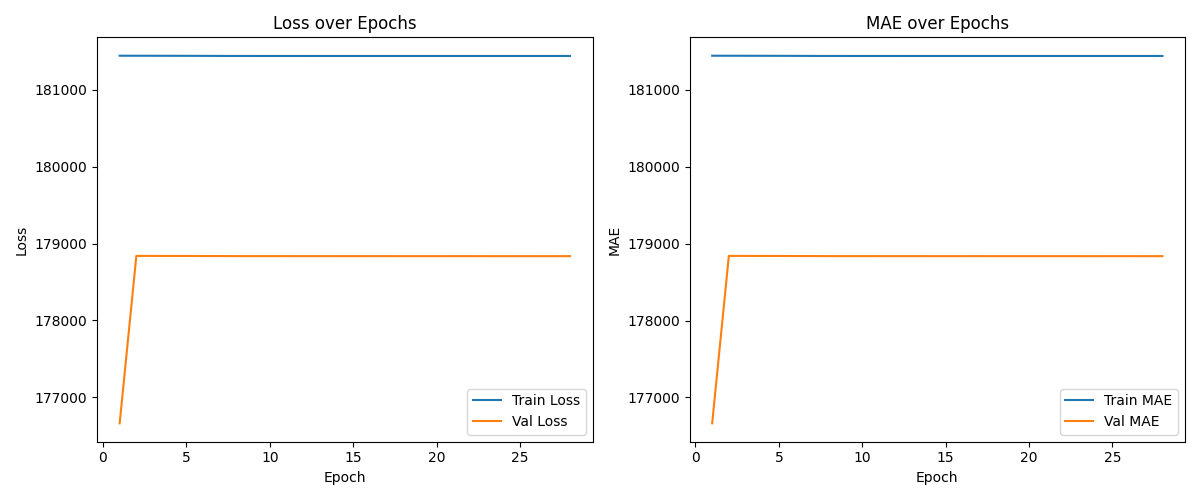

In [271]:
from PIL import Image
Image.open("metrics_plot.png")